In [1]:
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import itertools
import BoardExtractor
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten
import Piece_Classifier

In [2]:
train_datagen = ImageDataGenerator(
        rotation_range=2, # rotation
        # width_shift_range=0.1, # horizontal shift
        # height_shift_range=0.1, # vertical shift
        zoom_range=0.1, # zoom
        # shear_range=0.1,
        horizontal_flip=True, # horizontal flip
        # brightness_range=[0.2,1.2],
        validation_split=0.2) # brightness

train_generator = train_datagen.flow_from_directory(
    "Dataset/",
    target_size=(64,64),
    batch_size=16,
    class_mode='categorical',
    subset='training'
)
valid_generator = train_datagen.flow_from_directory(
    "Dataset/",
    target_size=(64,64),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

Found 2916 images belonging to 12 classes.
Found 720 images belonging to 12 classes.


In [3]:
model = Sequential()
model.add(Conv2D(128, kernel_size=(5,5), padding='valid',input_shape=train_generator.image_shape,activation='relu' ))
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='valid'))
model.add(Conv2D(256, kernel_size=(3,3),strides=(1,1), padding='same',activation='relu' ))
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='valid'))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(12,activation='softmax'))

In [4]:
model.load_weights('best_model_multi.h5')

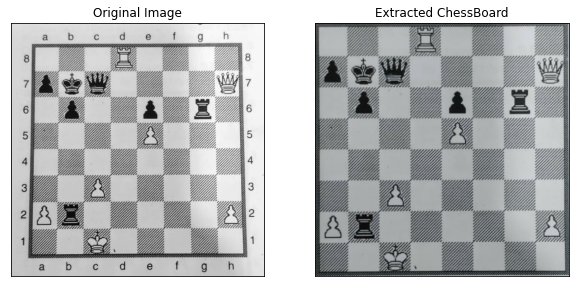

In [5]:
chessboard = BoardExtractor.get_chessboard('TEST/Boards/TestBoard1.jpeg')

In [7]:
chessboard = cv2.resize(chessboard,(512,512))

In [8]:
squares = BoardExtractor.get_chessboard_squares(chessboard)
print(squares.shape)

(64, 64, 64, 3)


In [13]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

{0: 'B-Bishop', 1: 'B-King', 2: 'B-Knight', 3: 'B-Pawn', 4: 'B-Queen', 5: 'B-Rook', 6: 'W-Bishop', 7: 'W-King', 8: 'W-Knight', 9: 'W-Pawn', 10: 'W-Queen', 11: 'W-Rook'}


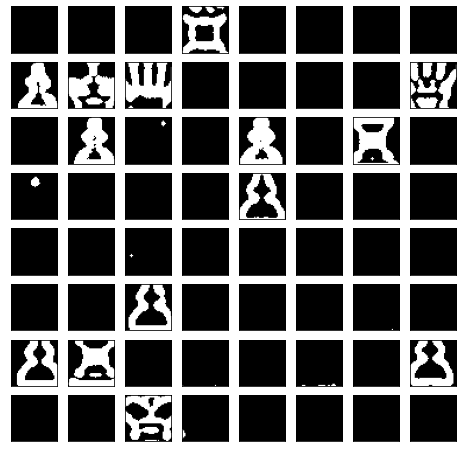

In [14]:
predictions = []
fig = plt.figure(figsize=(8, 8))
columns = 8
rows = 8
for i in range(64):
    img = squares[i]
    temp = img.copy()
    temp = BoardExtractor.preprocess_image(cv2.cvtColor(temp,cv2.COLOR_BGR2GRAY))
    temp = temp[12:52,12:52]
    fig.add_subplot(rows, columns, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(temp,cmap='gray')
    #check if the square is empty
    if np.sum(temp)/(40*40*255) < 0.2:
        predictions.append('Empty')
        continue
    pred = np.argmax(model.predict(np.array([img])),axis=1)
    predictions.append(labels[pred[0]])
plt.show()

In [15]:
for i in range(8):
    for j in range(8):
        print(predictions[i*8+j],end=" ")
    print()

Empty Empty Empty W-Rook Empty Empty Empty Empty 
B-Pawn B-King B-Queen Empty Empty Empty Empty W-Queen 
Empty B-Pawn Empty Empty B-Pawn Empty B-Rook Empty 
Empty Empty Empty Empty W-Pawn Empty Empty Empty 
Empty Empty Empty Empty Empty Empty Empty Empty 
Empty Empty W-Pawn Empty Empty Empty Empty Empty 
W-Pawn B-Rook Empty Empty Empty Empty Empty W-Pawn 
Empty Empty W-King Empty Empty Empty Empty Empty 


In [16]:
train_generator.class_indices.keys()

dict_keys(['B-Bishop', 'B-King', 'B-Knight', 'B-Pawn', 'B-Queen', 'B-Rook', 'W-Bishop', 'W-King', 'W-Knight', 'W-Pawn', 'W-Queen', 'W-Rook'])

In [17]:
fen_not = {
    'B-Bishop':'b',
    'B-King':'k',
    'B-Knight':'n',
    'B-Pawn':'p',
    'B-Queen':'q',
    'B-Rook':'r',
    'W-Bishop':'B',
    'W-King':'K',
    'W-Knight':'N',
    'W-Pawn':'P',
    'W-Queen':'Q',
    'W-Rook':'R',
    'Empty':'1'
}

In [18]:
rows = []
for i in range(8):
    row = ""
    for j in range(8):
        row += fen_not[predictions[i*8+j]]
    rows.append(row)
rows = '/'.join(rows)
print(rows)

111R1111/pkq1111Q/1p11p1r1/1111P111/11111111/11P11111/Pr11111P/11K11111


In [19]:
import urllib.request
fen_url = 'https://chessboardimage.com/{}.png'.format(rows)
  
urllib.request.urlretrieve(
  fen_url,
   "result.png")

result_img = cv2.imread('result.png')

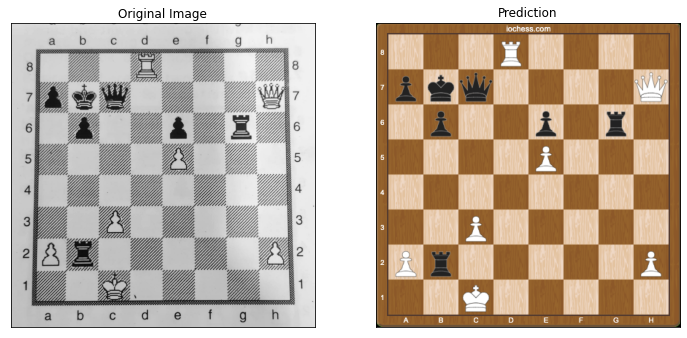

In [21]:
fig = plt.figure(figsize=(12,12))

fig.add_subplot(1,2,1)
plt.imshow(cv2.imread('TEST/Boards/TestBoard1.jpeg',0),cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Original Image')

fig.add_subplot(1,2,2)
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.title('Prediction')

plt.show()

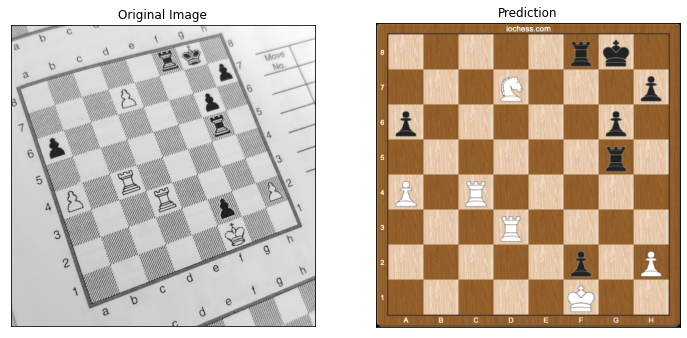

In [14]:
Piece_Classifier.get_prediction('TEST/Boards/TestBoard2.jpeg')